Hyperparameters definition and loading of CIFAR100 from pytorch torchvision

In [3]:
from comet_ml import Experiment
import torch
import torchvision
import torchvision.transforms as transforms

train_portion = 0.7

#controllare che len(val) è len(train)

#hyperparameters
batch_size = 250

#pad_totensor_transform = transforms.Compose([transforms.Pad(2), transforms.ToTensor()]) # does the padding, images 32x32 become 36x36 (symmetric increase) so that are divisible by three and patches are 12x12
#pad_totensor_transform = transforms.Compose([transforms.ToTensor()]) #no pad, no normalization
randAugm_numops = 2
randAugm_magn = 15
my_transforms = transforms.Compose([ transforms.RandAugment(num_ops = randAugm_numops,magnitude = randAugm_magn ),
                            transforms.ToTensor(), #nota importante, ToTensor dev'essere sempre come ultima trasformazione
                            ])

root = './cifar100_data' #if not in lab
#root = '../datasets/cifar100'


dataset = torchvision.datasets.CIFAR100(root=root, train=True, transform = my_transforms, download=True)
train_subset, val_subset = torch.utils.data.random_split(dataset, [int(train_portion*len(dataset)), len(dataset) - int(train_portion*len(dataset))], generator=torch.Generator().manual_seed(1))
test_dataset = torchvision.datasets.CIFAR100(root=root, train=False, transform = my_transforms)


train_loader = torch.utils.data.DataLoader(dataset=train_subset, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(dataset=val_subset, shuffle=False, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print(f"BATCH SIZE: {batch_size}")
print(f"Tran subset len: {len(train_subset)}")
print(f"Tran loader len: {len(train_loader)}")
print(f"Test: {len(train_subset)/batch_size}")

print(f"Val subset len: {len(val_subset)}")
print(f"Val subset len: {len(val_loader)}")
print(f"Test: {len(val_subset)/batch_size}")


print(f"Test subset len: {len(test_dataset)}")
print(f"Test subset len: {len(test_loader)}")
print(f"Test: {len(test_dataset)/batch_size}")


Files already downloaded and verified
BATCH SIZE: 250
Tran subset len: 35000
Tran loader len: 140
Test: 140.0
Val subset len: 15000
Val subset len: 60
Test: 60.0
Test subset len: 10000
Test subset len: 40
Test: 40.0


torch.Size([250, 3, 32, 32]) torch.Size([250])
torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


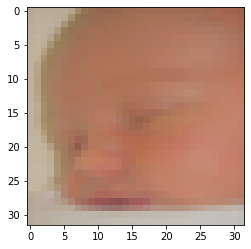

In [10]:
#test dataloader

examples = iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels.shape)

import matplotlib.pyplot as plt

img_sample = samples[0]
print(img_sample.shape)
print(img_sample.shape)
plt.imshow(img_sample.permute(1, 2, 0))
plt.show()

**Training loop**

In [ ]:
#device

In [11]:
#!conda install einops
from mlp_mixer import *
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
import json
import time

In [12]:
def get_accuracy(predicted, true_labels):
    predicted = torch.argmax(predicted.cpu(), dim=1)
    return accuracy_score(predicted, true_labels.cpu()) #forse questi passaggi a cpu non sono molto efficienti..

def generate_folder():
    import time
    import os
    import os.path
    datetime = time.strftime("%Y%m%d-%H%M%S")

    folder = f"./models/{datetime}/"
    os.chdir(".")
    print("current dir is: %s" % (os.getcwd()))

    if os.path.isdir(folder):
        print("Exists")
    else:
        os.mkdir(folder)
    return folder

#def save_model(model, path):
#    filename = path + f"{filename}.pth"
#    print(filename)
#    torch.save(model.state_dict(), filename)    

In [13]:
# credits https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py 
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [15]:

experiment = Experiment(
    api_key="xX6qWBFbiOreu0W3IrO14b9nB",
    project_name="mlp-mixer",
    workspace="wedrid",
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_width_height = img_sample.shape[1]
patch_dims = 4
# variable_name = value #paper value
n_channels = 32 #128 #256 #100 #512 #embed dim
loss_func = nn.CrossEntropyLoss()
learning_rate = 0.001
weight_decay = 0.1
num_layers = 7 #8
mlp_dc_dimension = 512 #512 #1024 #2048 # dc è la dimensione del channel mixing (l'ultimo mlp)
mlp_ds_dimension = 64 #64 #128 #256 # ds è la dimensione del token mixing (il primo)

mixup = True
mixup_alpha = 0.5

model = MLP_mixer(img_h_w=image_width_height, patch_dim=patch_dims, n_channels=n_channels, num_mixers_layers=num_layers,
    hidden_dim_mlp_token=mlp_ds_dimension, hidden_dim_mlp_channel=mlp_dc_dimension) #in this case 2 patches 16x16
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay) 

num_epochs = 500
steps_total = len(train_loader)

#ATTENZIONE: CAMBIARE IPERPARAMETRI ***PRIMAAAA*** DEL DICT SUCCESSIVO

hyper_params = {
    "dataset": root,
    "rand_augm_numops": randAugm_numops,
    "rand_augm_magnitude": randAugm_magn,
    "comment": 'added weight decay',
    "train_size": len(train_loader),
    "validation_size": len(val_loader),
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "steps": steps_total,
    "batch_size": batch_size,
    "mixup_alpha": mixup_alpha, 
    "image_width_and_height": image_width_height,
    "patch_width_and_height": patch_dims,
    "hidden_dim_size (n_channels)": n_channels,
    "number_of_layers": num_layers,
    "mlp_dc_dimension": mlp_dc_dimension,
    "mlp_ds_dimension": mlp_ds_dimension
}

experiment.log_parameters(hyper_params)
model_path = generate_folder()
with open(model_path+"/params.json", "w") as file:
    json.dump(hyper_params, file, indent=4)

model.to(device)
# training loop
for epoch in tqdm(range(num_epochs)):
    start = time.time()
    model.train()
    train_accuracy = 0
    #for i, (images, labels) in enumerate(tqdm(train_loader)):
    for i, (images, labels) in enumerate(train_loader):
        # [100, 3, 36, 36] is what is returned by iterator
        images = images.to(device)
        labels = labels.to(device)
        if not mixup: #without mixup regularization
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            
        else:
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha=mixup_alpha)
            #images, labels_a, labels_b = map(Variable, ) no because Variable is deprecated
            predicted = model(images)
            loss = mixup_criterion(loss_func, predicted, labels_a, labels_b, lam)
            
        train_accuracy += get_accuracy(predicted, labels)
        # backwards pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if False and (i+1) % 100:
            print(f'epoch: {epoch+1} of {num_epochs}, step {i+1} of {steps_total}, loss = {loss.item():.4f}')
    print(f"Loss of epoch {epoch+1}: {loss.item():.4f}")
    train_accuracy /= len(train_loader)
    #print(f"TRAIN LOADER LENGTH: {len(train_loader)}")
    end = time.time()
    elapsed = end - start
    experiment.log_metric("train epoch loss", loss.item(), step = epoch)
    experiment.log_metric("mean train epoch accuracy", train_accuracy, step = epoch)
    experiment.log_metric("epoch time", elapsed, step = epoch)
    # validation
    with torch.no_grad():
        model.eval()
        val_accuracy = 0
        temp = 0
        for i, (images, labels) in enumerate(tqdm(val_loader)): #numero esempi/batchsize TODO check
            # [100, 3, 36, 36] is what is returned by iterator
            images = images.to(device)
            labels = labels.to(device)
            
            # forward pass
            predicted = model(images)
            loss = loss_func(predicted, labels)
            val_accuracy += get_accuracy(predicted, labels)
        #print(f"Lenght val loader: {len(val_loader)}, counter: {temp}")
        val_accuracy /= len(val_loader) 
        experiment.log_metric("val epoch loss", loss.item(), step=epoch) #TODO average loss?
        experiment.log_metric("mean val epoch accuracy", val_accuracy, step=epoch)
    
    if epoch % 10 == 0:
        torch.save(model.state_dict(), model_path + f"checkpoint_epch_{epoch}.pth")
torch.save(model.state_dict(), model_path + f"final.pth")


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wedrid/mlp-mixer/06407738ff2b4128a1d51f998454715b
COMET INFO:   Parameters:
COMET INFO:     batch_size                   : 250
COMET INFO:     comment                      : added weight decay
COMET INFO:     dataset                      : ./cifar100_data
COMET INFO:     epochs                       : 500
COMET INFO:     hidden_dim_size (n_channels) : 32
COMET INFO:     image_width_and_height       : 32
COMET INFO:     learning_rate                : 0.001
COMET INFO:     mlp_dc_dimension             : 128
COMET INFO:     mlp_ds_dimension             : 32
COMET INFO:     number_of_layers             : 5
COMET INFO:     patch_width_and_height       : 4
COMET INFO:     steps                        : 140
COMET INFO:     train_size                   : 

current dir is: /Users/edrid/Desktop/Machine learning/Project/mlp_mixer


  0%|          | 0/500 [00:00<?, ?it/s]

Loss of epoch 1: 4.5837


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 2: 4.5493


  0%|          | 0/60 [00:00<?, ?it/s]

Loss of epoch 3: 4.5665


  0%|          | 0/60 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
if False: 
    examples = iter(train_loader)
    images, labels = examples.next()

    # metrics trial
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = loss_func(outputs, labels)

    #da mettere nel ciclo
    print(outputs.shape)

    #####
    predicted = torch.argmax(outputs, dim=1)
    accuracy = accuracy_score(predicted, labels)
    print(f'Accuracy {accuracy}')
    #####
    print(predicted.shape)
    print(predicted)
